Define the period that you want to forecast

In [1]:
futurePeriod = 24

# Import Libraries

In [2]:
# import relevant libraries
import pandas as pd
import numpy as np
import tensorflow
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from keras.models import Sequential
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

# Load data

In [20]:
# read data
df = pd.read_csv('sample_data.csv')

# EDA

In [21]:
# check data
df.head()

,datetime,7,9
0,07/24/05 00:00:00,0,0
1,07/24/05 00:30:00,1,0
2,07/24/05 01:00:00,0,0
3,07/24/05 01:30:00,0,0
4,07/24/05 02:00:00,0,0


In [22]:
# check missing values
df.isnull().sum()

datetime    0
7           0
9           0
dtype: int64

In [23]:
# separate the series 7
close = df['7']

Timeseries plot


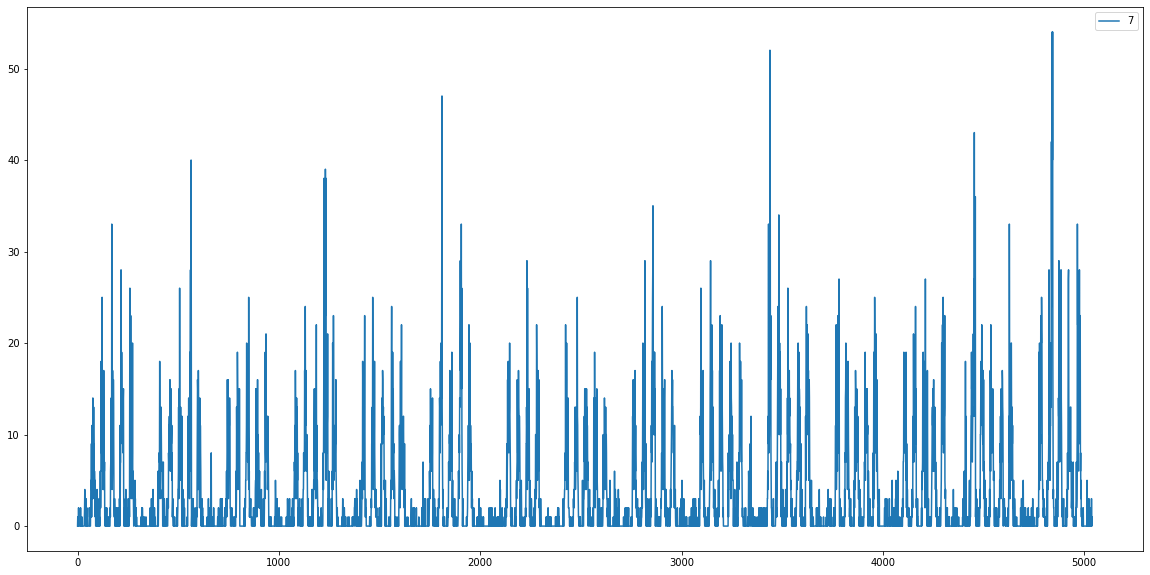

In [24]:
# plot the timeseries
print('Timeseries plot')
plt.plot(close, label = '7')
plt.legend()

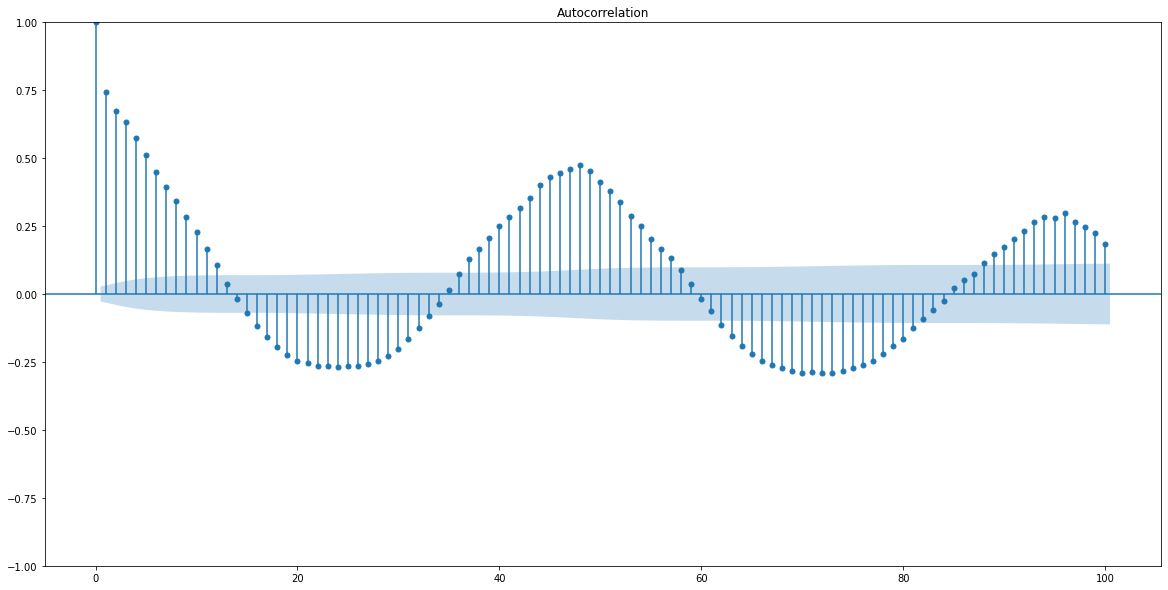

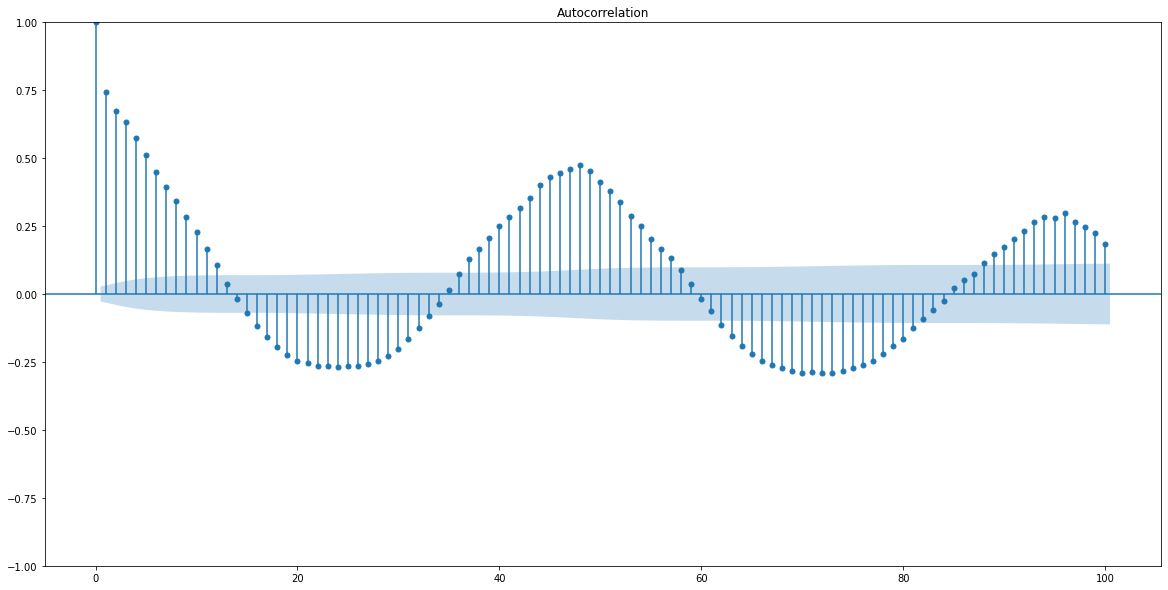

In [25]:
# acf plot
plot_acf(close, lags = 100)

c:\users\administrator\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


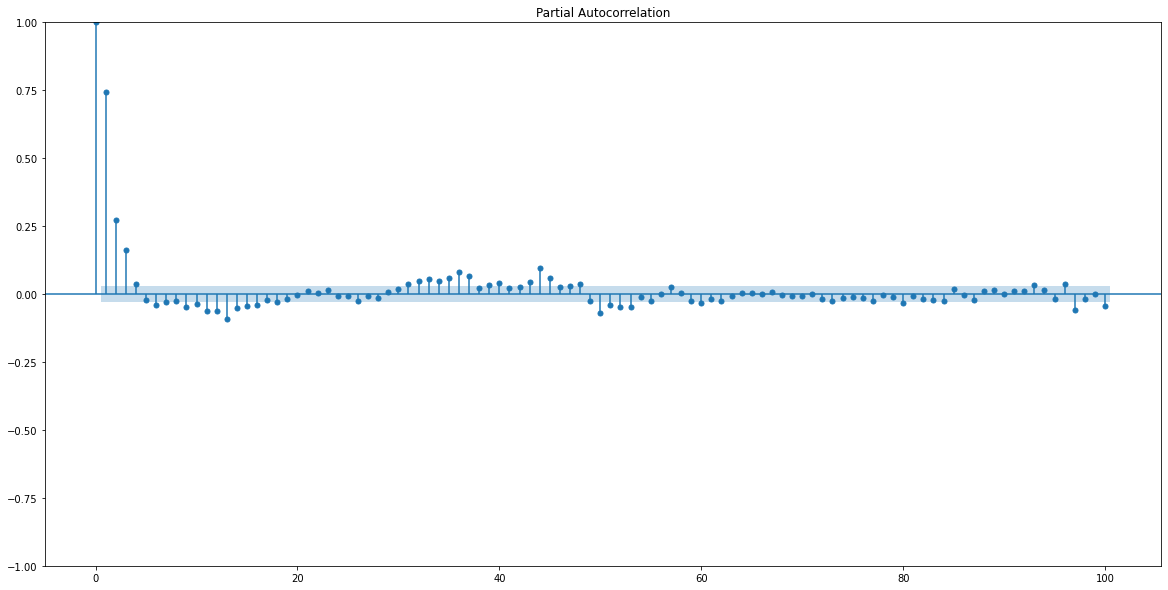

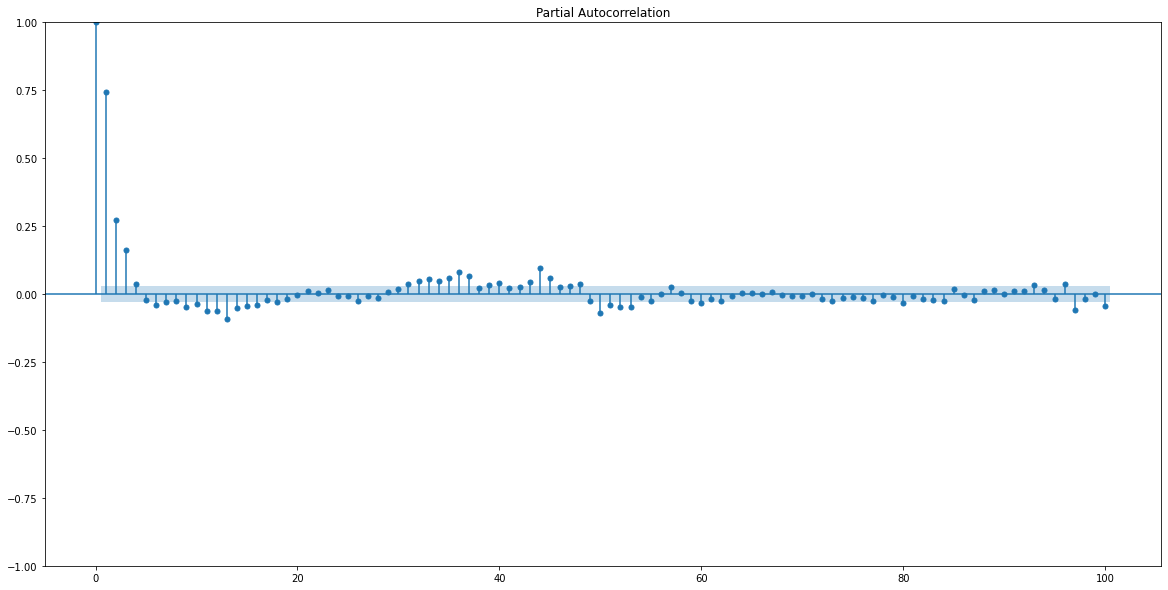

In [26]:
# pacf plot
plot_pacf(close, lags = 100)

The data is highly seasonal

In [27]:
# ADF test
result = adfuller(close)
print('ADF TEST \n')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF TEST 

ADF Statistic: -11.583737
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


From the above summary, p value = 0.00 and t value = -11.583737

At p-value < alpha = 0.05, we can reject the null hypothesis at 95% confidence level.

The series is stationary

In [30]:
# log transformation
close = close + 1 # to avoid "0"
close = np.log(close)

# Model Preparation

We first divide the dataset into train and test to find out the *suitable combination of Hyperparameters*

In [31]:
# train test split
train = close.iloc[:int(len(close)*0.8)]  #80% train
test = close.iloc[int(len(close)*0.2):]   #20% test

Function to prepare data for the LSTM

In [32]:
# function to prepare data for LSTM
def prepareData(data_lstm,lookback ,future):
    
    # convert the data_lstm into array form that is compatable with LSTM
    data_lstm = np.array(data_lstm.values).reshape(-1,1)
    
    # Lists to grab input and output sequences in the fly
    X_ = []
    Y_ = []
    
    # loop through the data
    for i in range(lookback, len(data_lstm) - future + 1):
        X_.append(data_lstm[i - lookback: i])
        Y_.append(data_lstm[i: i + future])
        
    # convert input and output sequences to array
    X_ = np.array(X_)
    Y_ = np.array(Y_)
    
    # return input and output sequences
    return(X_,Y_)

Function to train, evaluate, and save LSTM model

In [33]:
# LSTM train, evaluate and save function
def trainLstm(Xtrain,Ytrain, Xtest, Ytest, future, epoch):

    #initialize the weights
    np.random.seed(1)
    tensorflow.random.set_seed(1)

    # define model architecture
    model = Sequential()
    model.add(LSTM(20, activation='relu', return_sequences=True))
    model.add(LSTM(10, activation='relu', return_sequences=True))
    model.add(SimpleRNN(5, activation='relu'))
    model.add(Dense(future))
    model.compile(optimizer='RMSProp', loss='mse')

    # fit the model
    r = model.fit(Xtrain,Ytrain,epochs=epoch, validation_data=(Xtest, Ytest))
    
    # plotting training and validation loss
    acc = r.history['loss']
    val_acc = r.history['val_loss']
    loss = r.history['loss']
    val_loss = r.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    # making prediction
    y_p = model.predict(Xtest)
    
    predictions =[]
    # visualize and save predictions
    for i in range(future):
        plt.figure()
        plt.plot(y_p[:,i], label='Prediction', color='red',linestyle='dashed', linewidth=5)
        plt.plot(y_test[:,i], label ='Actual', color='yellow', linewidth=2)
        plt.legend()
        plt.title(f"{i + 1} step forecast")
        plt.show()
        
        # calculate performance matrices
        print(f"RMSE {i + 1} step forecast: {np.sqrt(mean_squared_error(y_p[:,i], y_test[:,i]))}")
        print(f"MAE {i + 1} step forecast: {np.sqrt(mean_absolute_error(y_p[:,i], y_test[:,i]))}")
        print(f"MAPE {i + 1} step forecast: {np.sqrt(mean_absolute_percentage_error(y_p[:,i], y_test[:,i]))}")
        
        # calculate standard deviation
        std_ = np.std(y_p[:,i])
        # calculate prediction interval
        l_limit = y_p[:,i] - 1.96*std_
        u_limit = y_p[:,i] + 1.96*std_
        # make a dataframe and append into predictions list
        predictions.append(pd.DataFrame({'Actual': y_test[:,i].flatten(), 'Pred': y_p[:,i], 'Pred Interval Lower': l_limit, 'Pred Interval Upper': u_limit}))
        
        
        
    # save model
    model.save('LSTM.h5')
    
    # return predictions
    return predictions

Prepare data by calling the prepareData function

In [34]:
# prepare train and test data
x_train, y_train = prepareData(train,4 ,futurePeriod)
x_test, y_test = prepareData(test,4 ,futurePeriod)

Train/evaluate/save by caling the trainLstm function

In [35]:
# cast the x_train into float64
x_train = tensorflow.cast(x_train, dtype='float64')

Epoch 1/50
126/126 [==============================] - 4s 8ms/step - loss: 1.8780 - val_loss: 1.2864
Epoch 2/50
126/126 [==============================] - 1s 5ms/step - loss: 0.8945 - val_loss: 0.7602
Epoch 3/50
126/126 [==============================] - 1s 5ms/step - loss: 0.6382 - val_loss: 0.6371
Epoch 4/50
126/126 [==============================] - 1s 5ms/step - loss: 0.5575 - val_loss: 0.5821
Epoch 5/50
126/126 [==============================] - 1s 6ms/step - loss: 0.5233 - val_loss: 0.5500
Epoch 6/50
126/126 [==============================] - 1s 5ms/step - loss: 0.5052 - val_loss: 0.5293
Epoch 7/50
126/126 [==============================] - 1s 5ms/step - loss: 0.4966 - val_loss: 0.5323
Epoch 8/50
126/126 [==============================] - 1s 5ms/step - loss: 0.4932 - val_loss: 0.5578
Epoch 9/50
126/126 [==============================] - 1s 5ms/step - loss: 0.4895 - val_loss: 0.5146
Epoch 10/50
126/126 [==============================] - 1s 5ms/step - loss: 0.4878 - val_loss: 0.5121

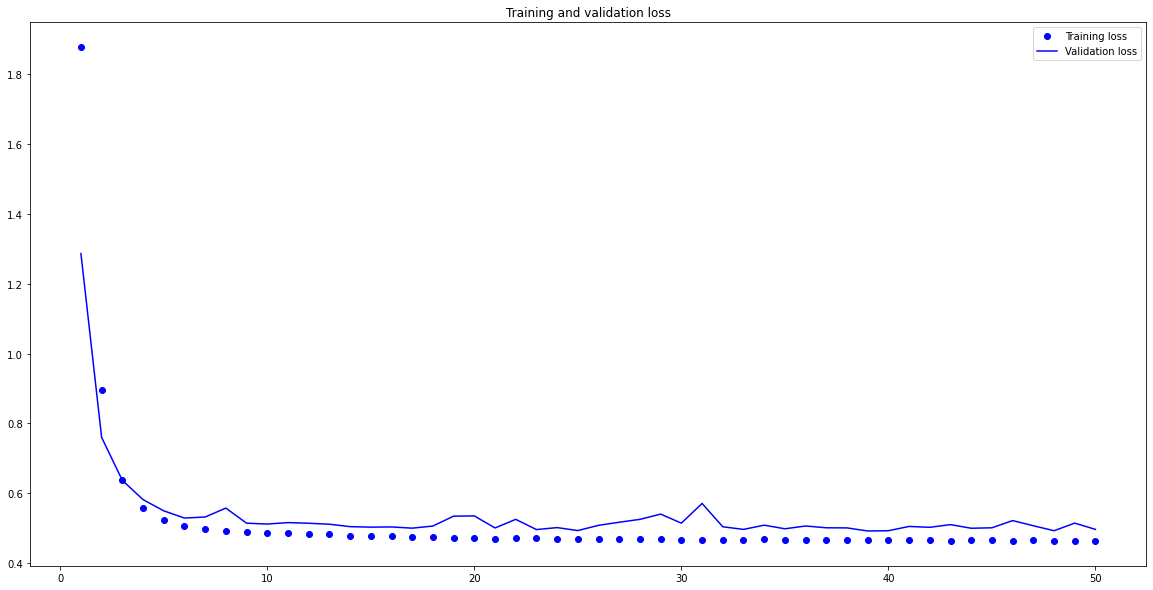

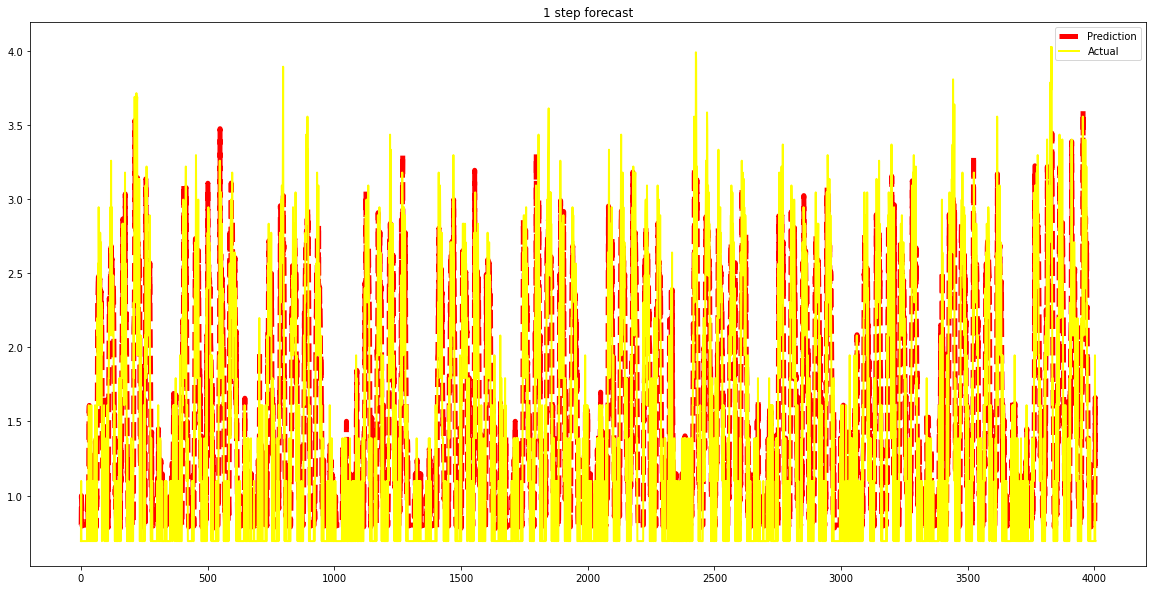

RMSE 1 step forecast: 0.4345435596617381
MAE 1 step forecast: 0.5777591679758617
MAPE 1 step forecast: 0.5002079059674224


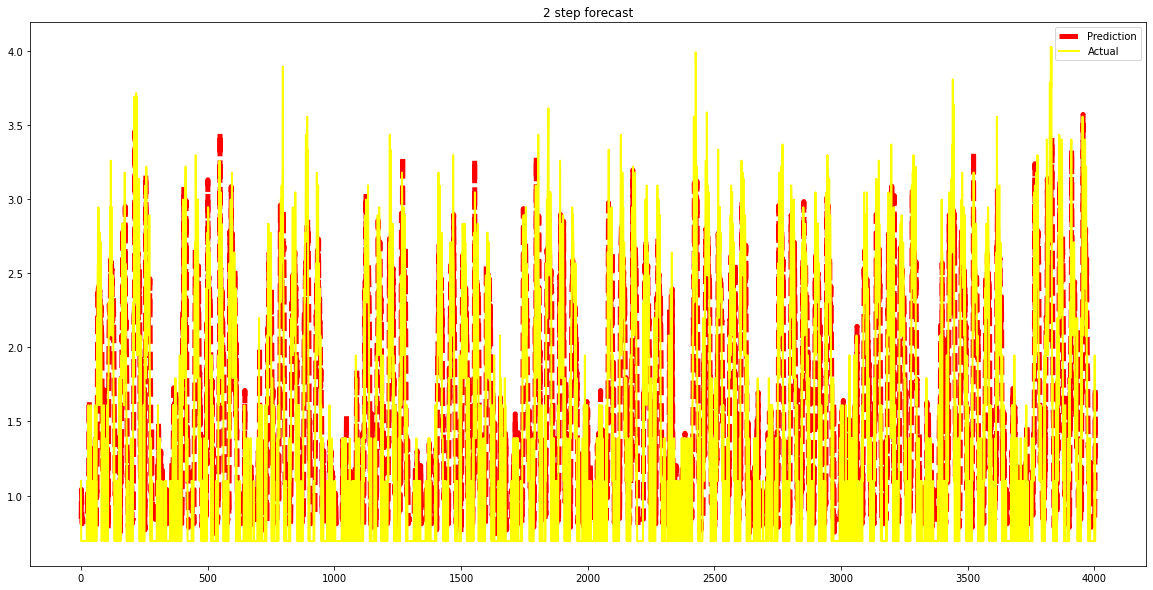

RMSE 2 step forecast: 0.4770934523095213
MAE 2 step forecast: 0.6088247914351614
MAPE 2 step forecast: 0.5232958518057099


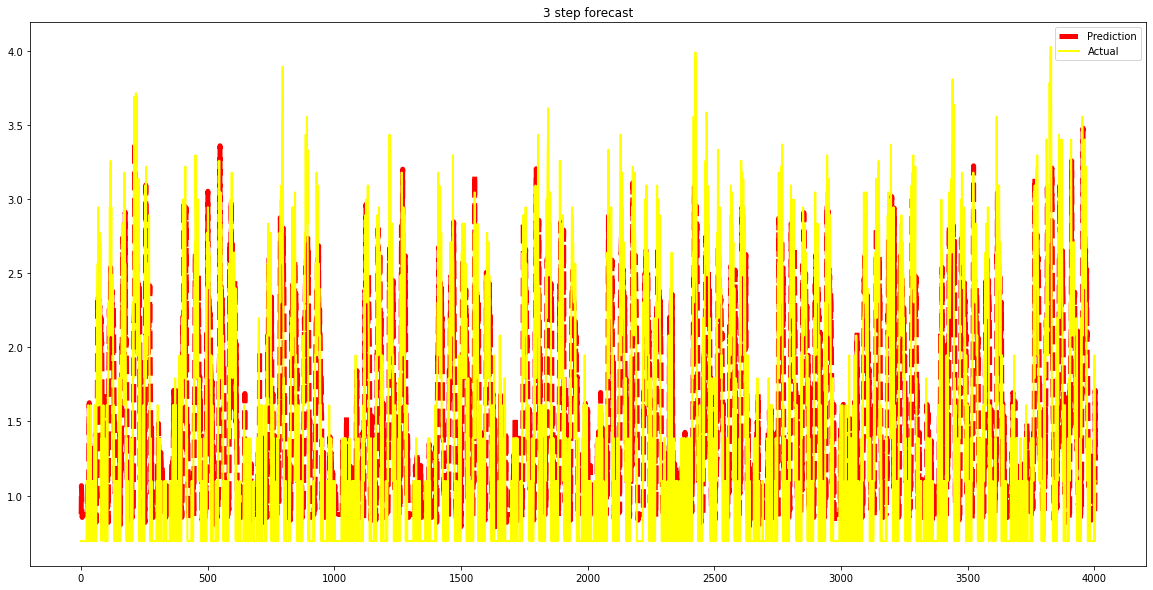

RMSE 3 step forecast: 0.5181265709825885
MAE 3 step forecast: 0.6357556070379959
MAPE 3 step forecast: 0.5470823073008827


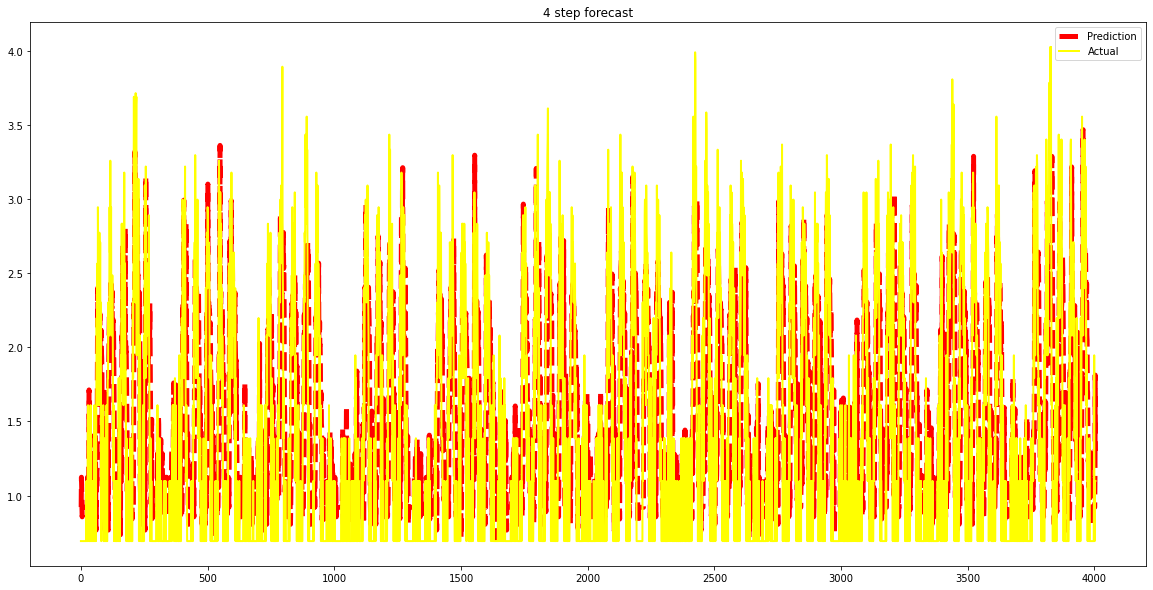

RMSE 4 step forecast: 0.5661878783960169
MAE 4 step forecast: 0.6672191677349774
MAPE 4 step forecast: 0.5722395524414688


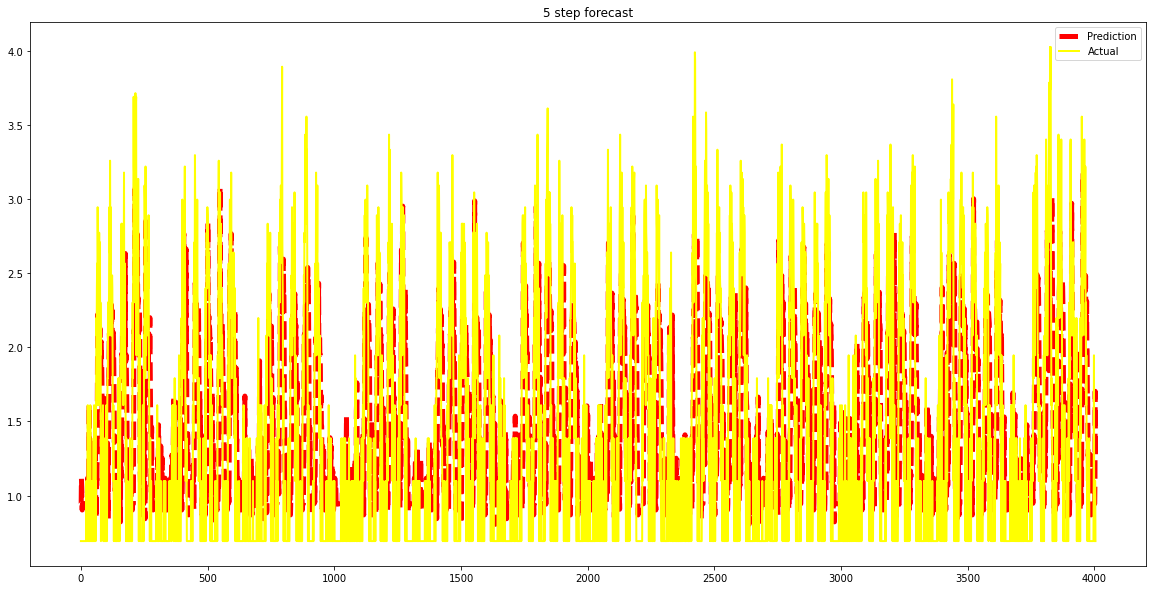

RMSE 5 step forecast: 0.6099536886357448
MAE 5 step forecast: 0.6941442134428829
MAPE 5 step forecast: 0.5975369401244768


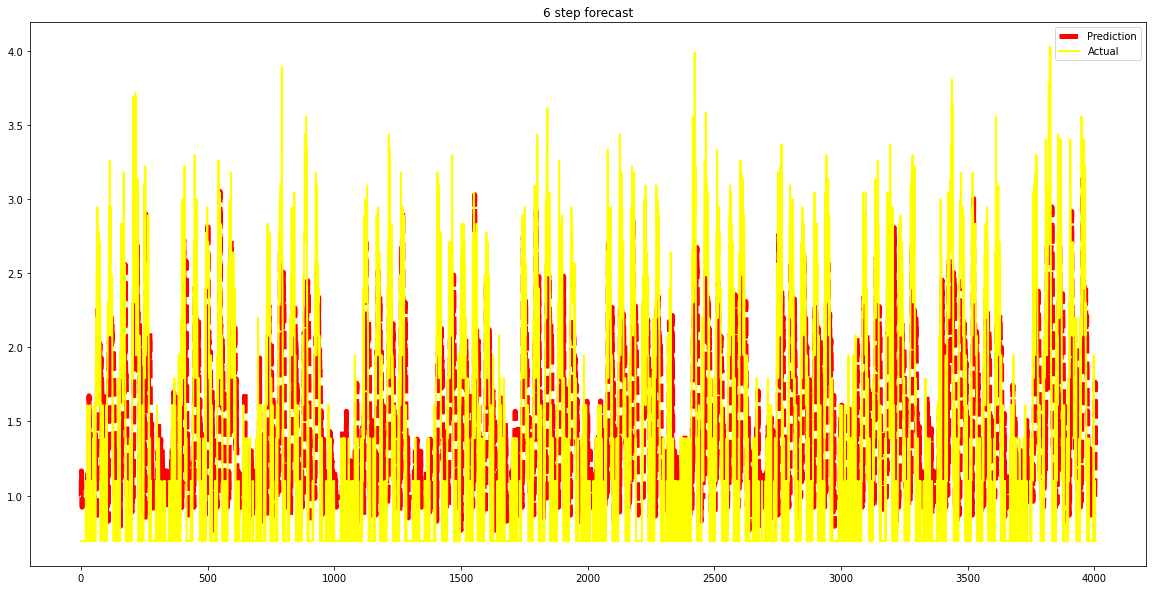

RMSE 6 step forecast: 0.6478309750949501
MAE 6 step forecast: 0.7164348423232665
MAPE 6 step forecast: 0.6186644496969043


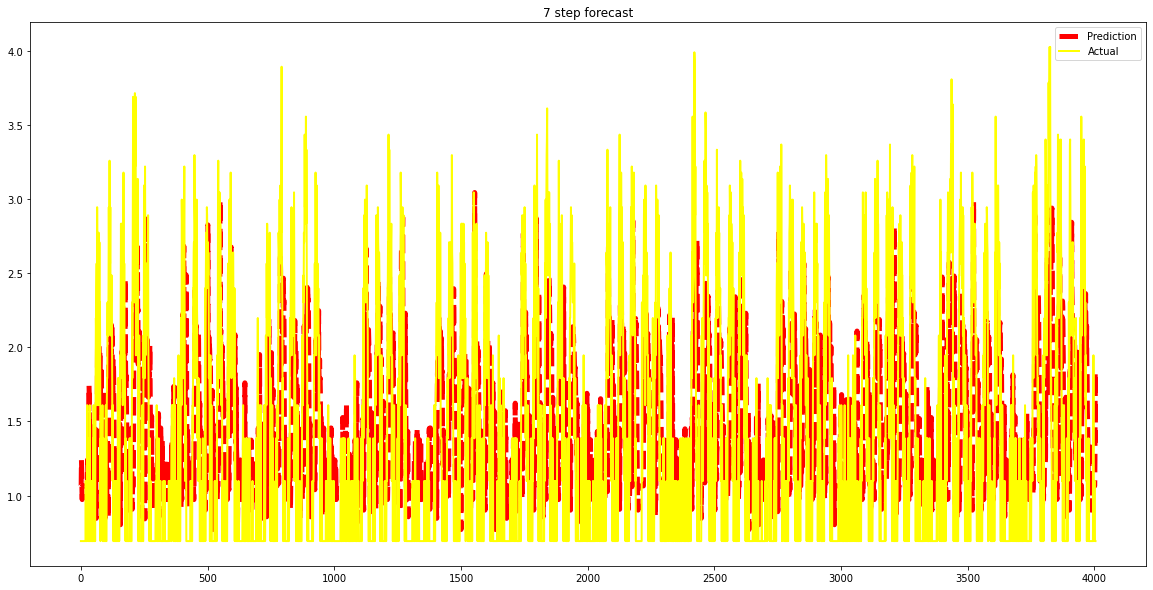

RMSE 7 step forecast: 0.6801514857228271
MAE 7 step forecast: 0.7391457004781092
MAPE 7 step forecast: 0.6317804111005306


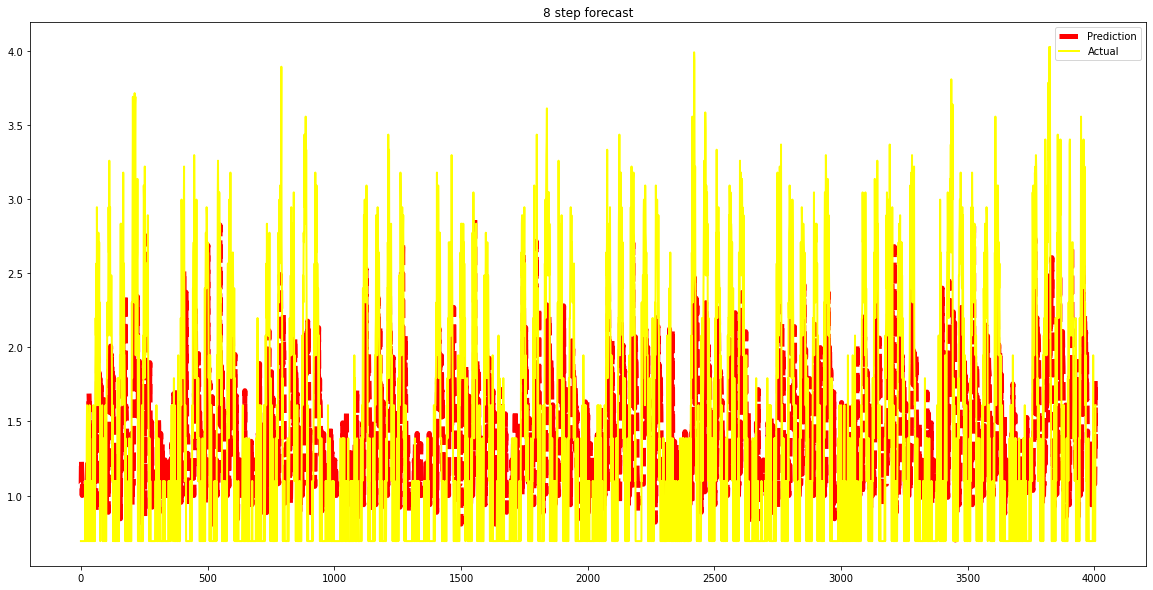

RMSE 8 step forecast: 0.7064749146072627
MAE 8 step forecast: 0.752939997847687
MAPE 8 step forecast: 0.6524846061260714


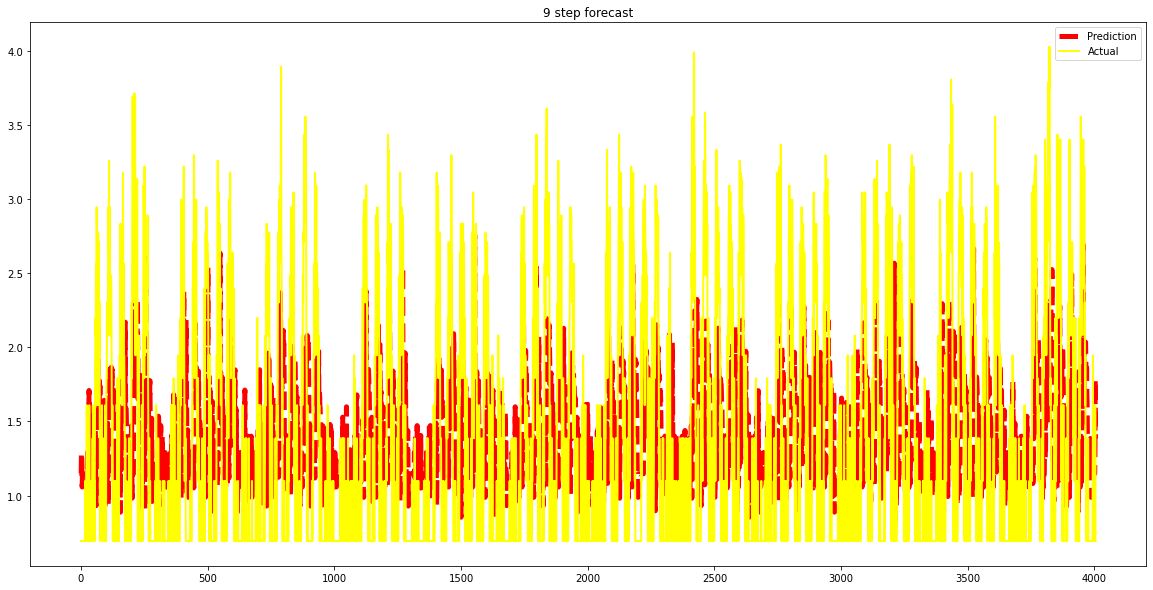

RMSE 9 step forecast: 0.7297313832317217
MAE 9 step forecast: 0.7718599742227106
MAPE 9 step forecast: 0.6630002622887214


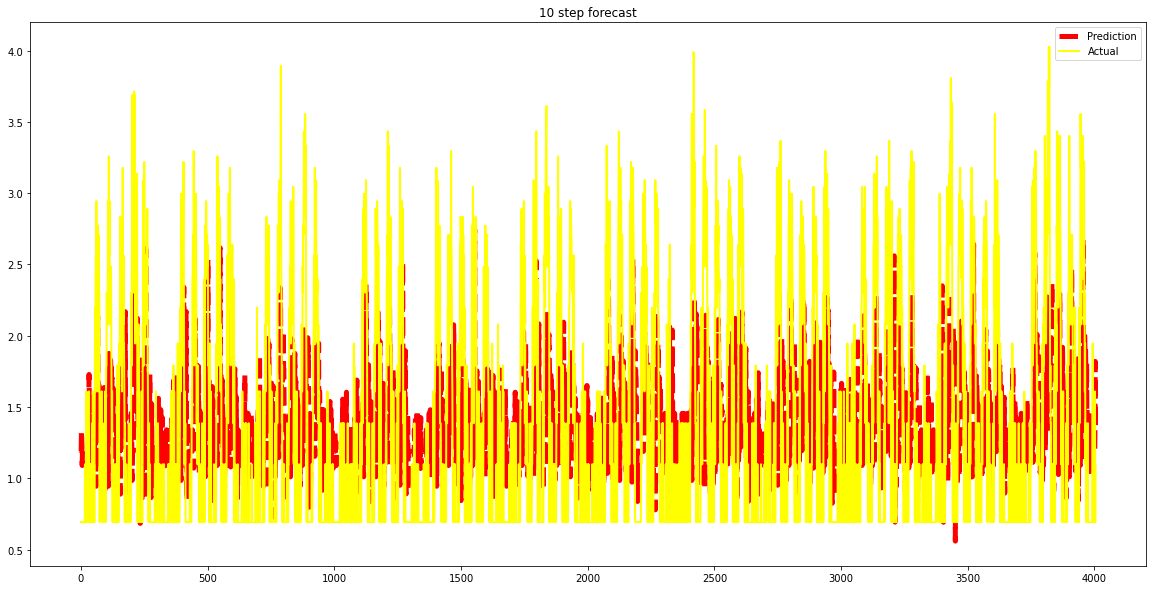

RMSE 10 step forecast: 0.7412073113700262
MAE 10 step forecast: 0.7773957465422203
MAPE 10 step forecast: 0.6723136657747056


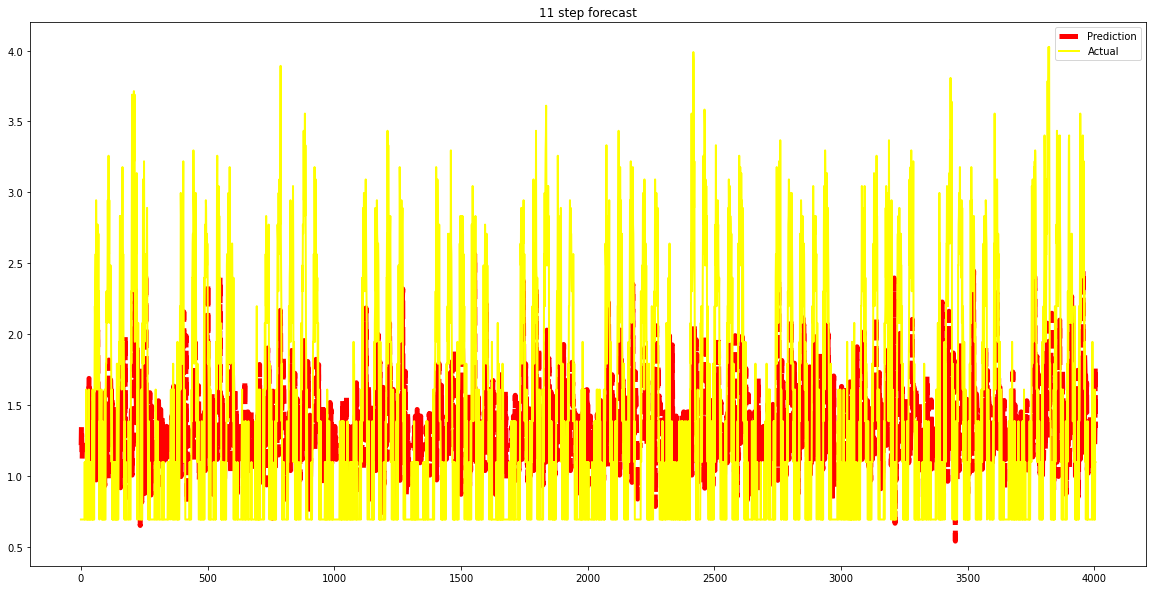

RMSE 11 step forecast: 0.756178920600375
MAE 11 step forecast: 0.7850939729928625
MAPE 11 step forecast: 0.6846820833589444


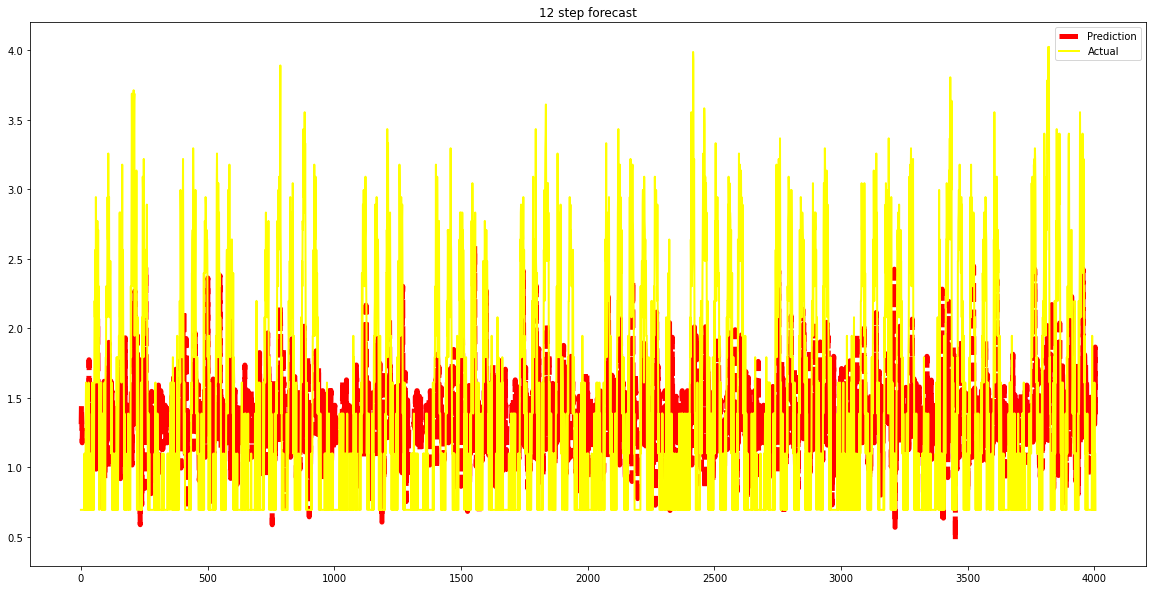

RMSE 12 step forecast: 0.7609812800962966
MAE 12 step forecast: 0.791027665399746
MAPE 12 step forecast: 0.6823538328002633


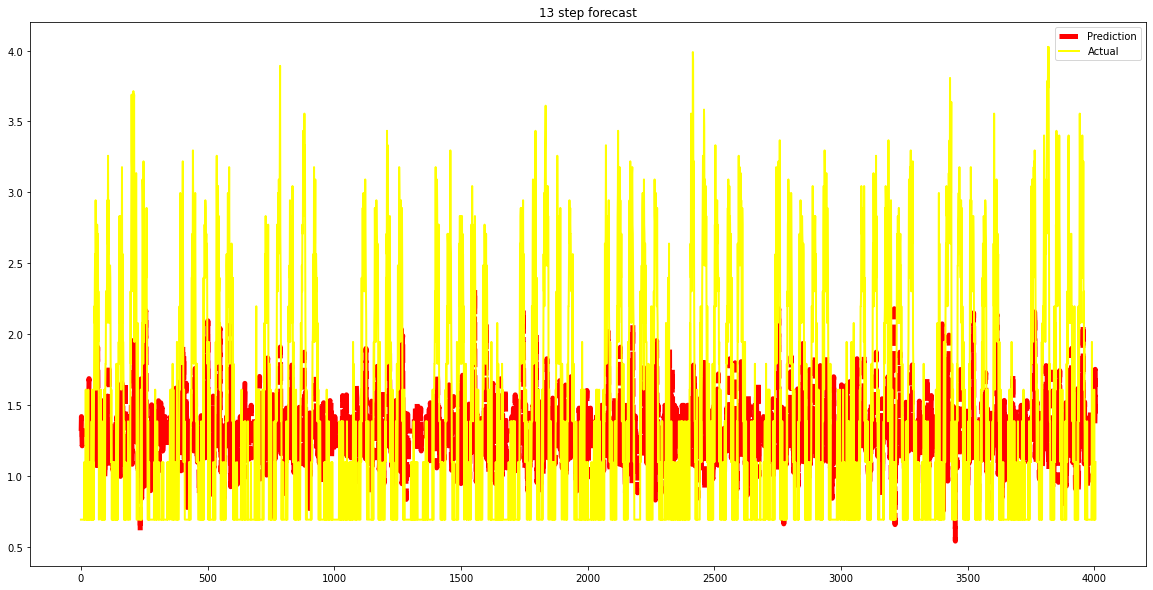

RMSE 13 step forecast: 0.7717063314368886
MAE 13 step forecast: 0.7928999050775665
MAPE 13 step forecast: 0.6932692138115801


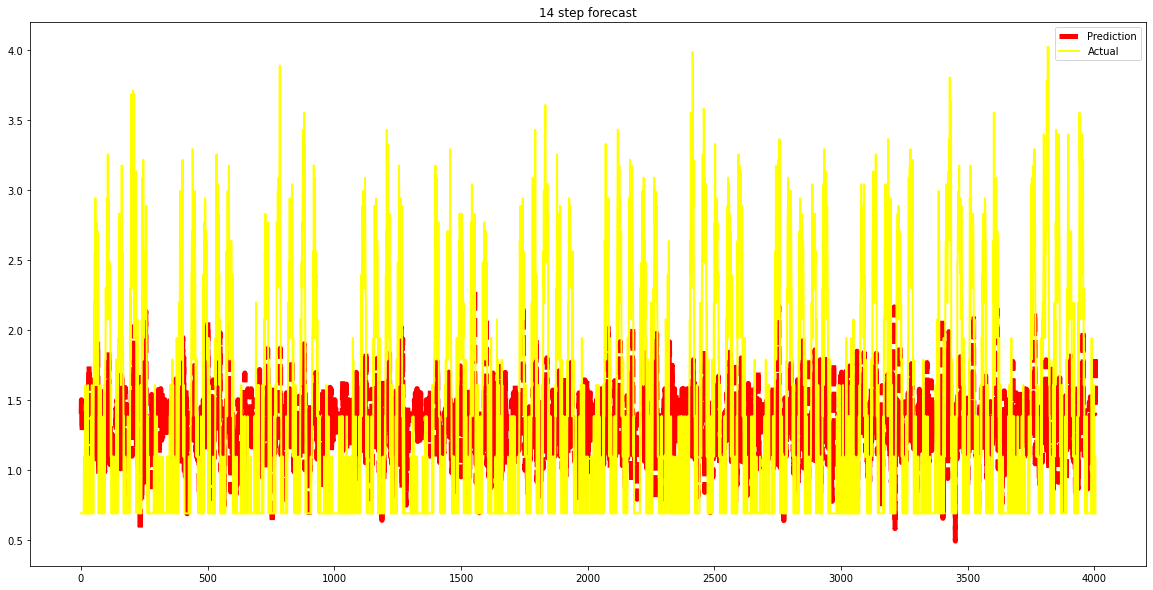

RMSE 14 step forecast: 0.769653783675564
MAE 14 step forecast: 0.793878103823465
MAPE 14 step forecast: 0.6874664769286631


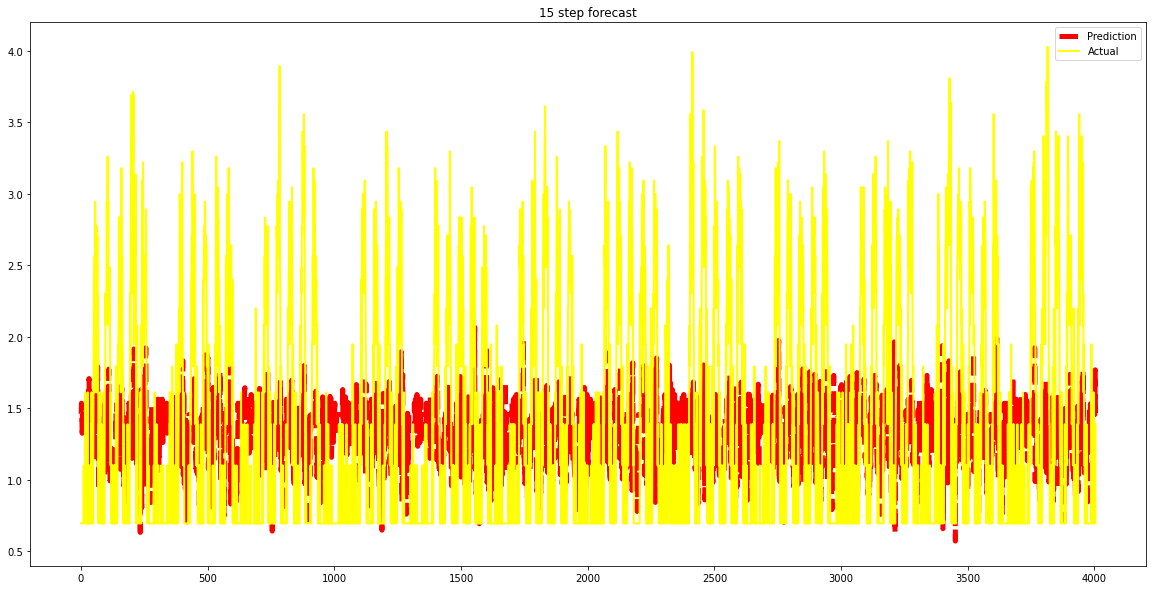

RMSE 15 step forecast: 0.7716595320649889
MAE 15 step forecast: 0.7956500915960649
MAPE 15 step forecast: 0.688025846666303


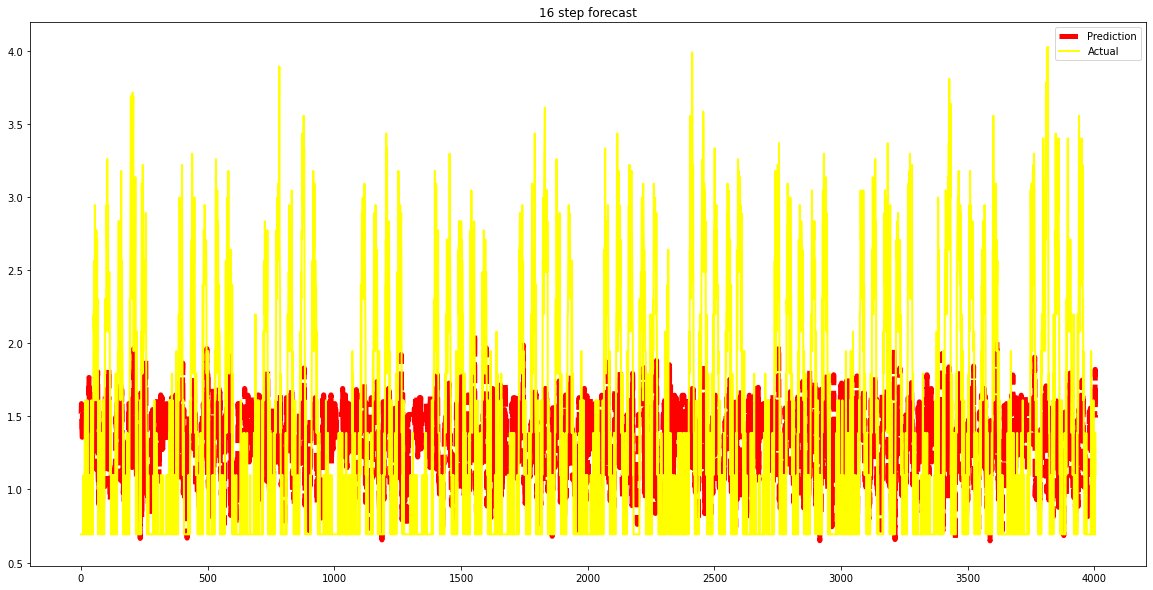

RMSE 16 step forecast: 0.7677211585173536
MAE 16 step forecast: 0.7944169983623129
MAPE 16 step forecast: 0.6850625229171519


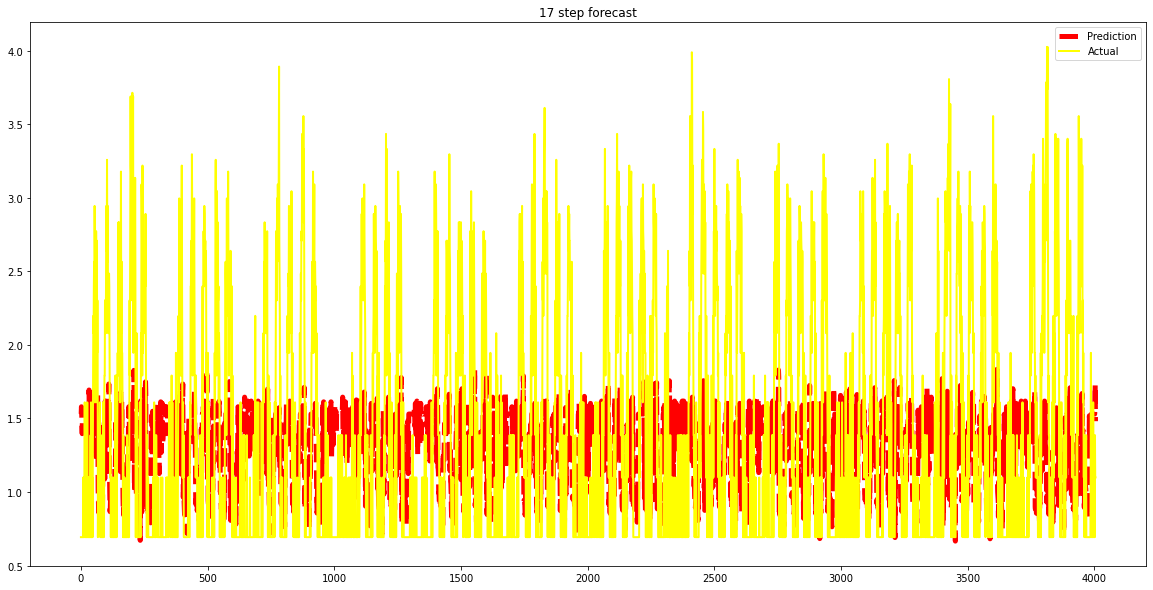

RMSE 17 step forecast: 0.7635662499824759
MAE 17 step forecast: 0.7903947381765281
MAPE 17 step forecast: 0.6855058763777895


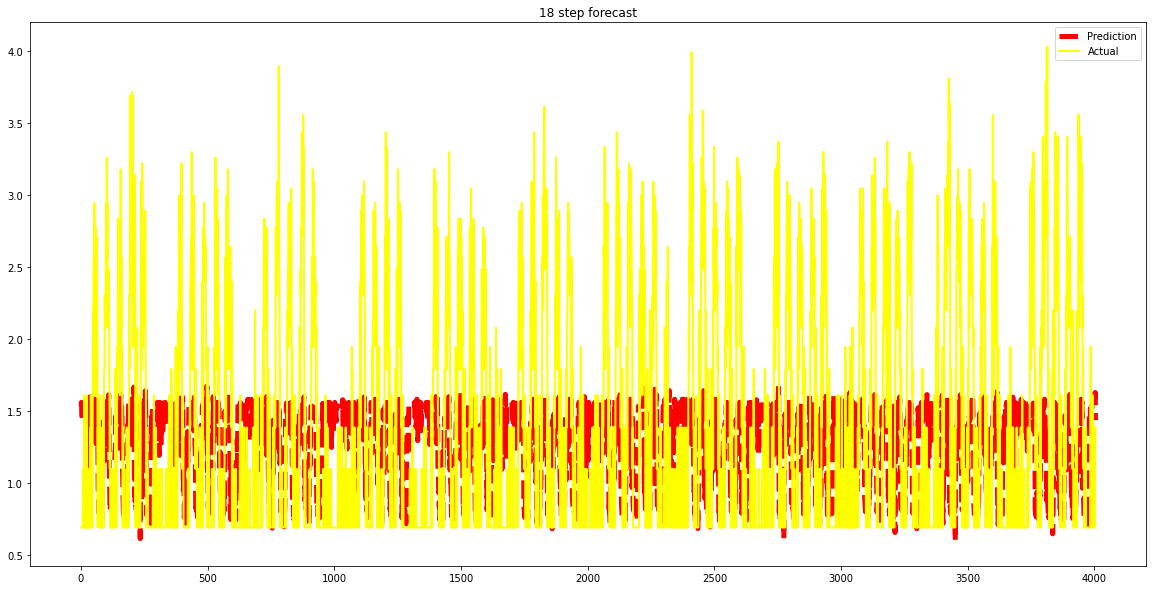

RMSE 18 step forecast: 0.7643216982227018
MAE 18 step forecast: 0.7847343168463782
MAPE 18 step forecast: 0.6868969921397138


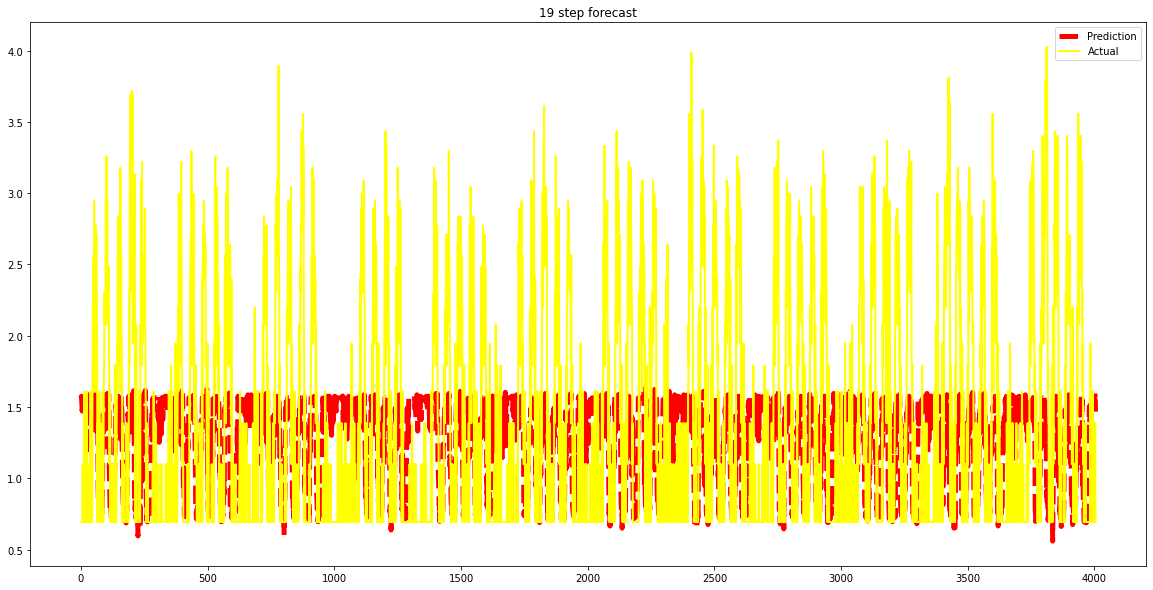

RMSE 19 step forecast: 0.7585172118194885
MAE 19 step forecast: 0.7798438014254768
MAPE 19 step forecast: 0.6795480946996395


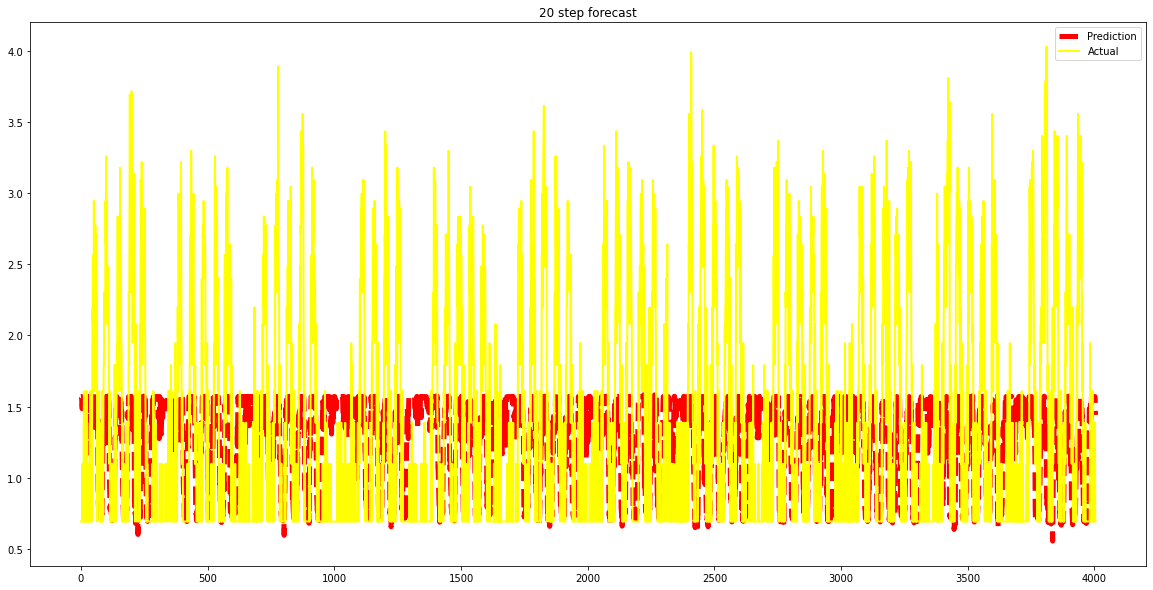

RMSE 20 step forecast: 0.7551548617216419
MAE 20 step forecast: 0.7744967699078694
MAPE 20 step forecast: 0.6754528109916559


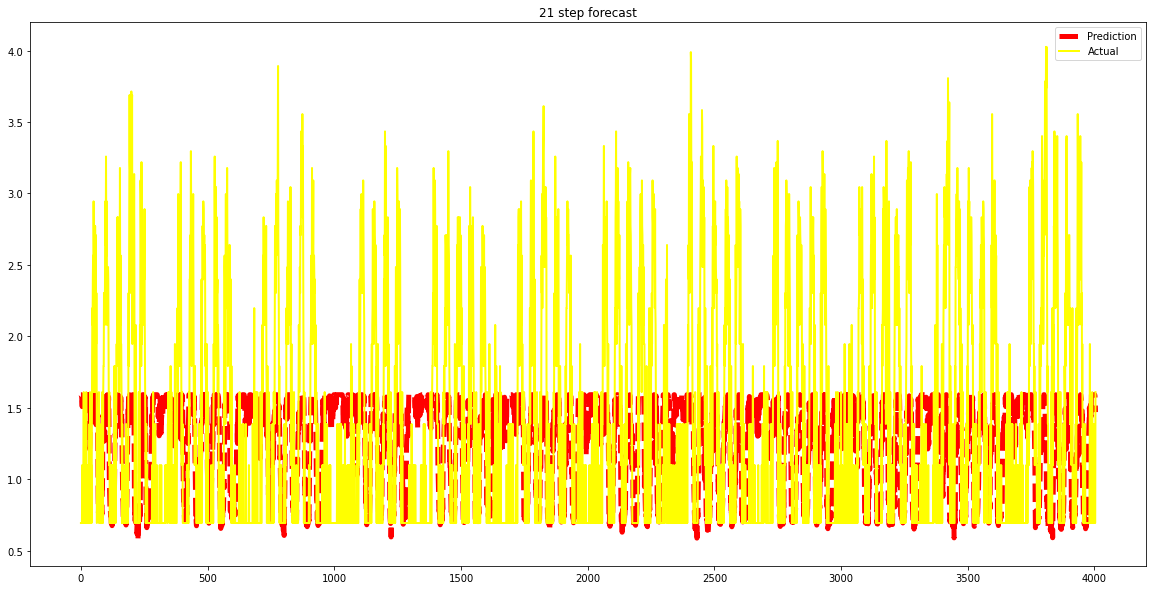

RMSE 21 step forecast: 0.750261748958474
MAE 21 step forecast: 0.770902268211958
MAPE 21 step forecast: 0.6684285936658598


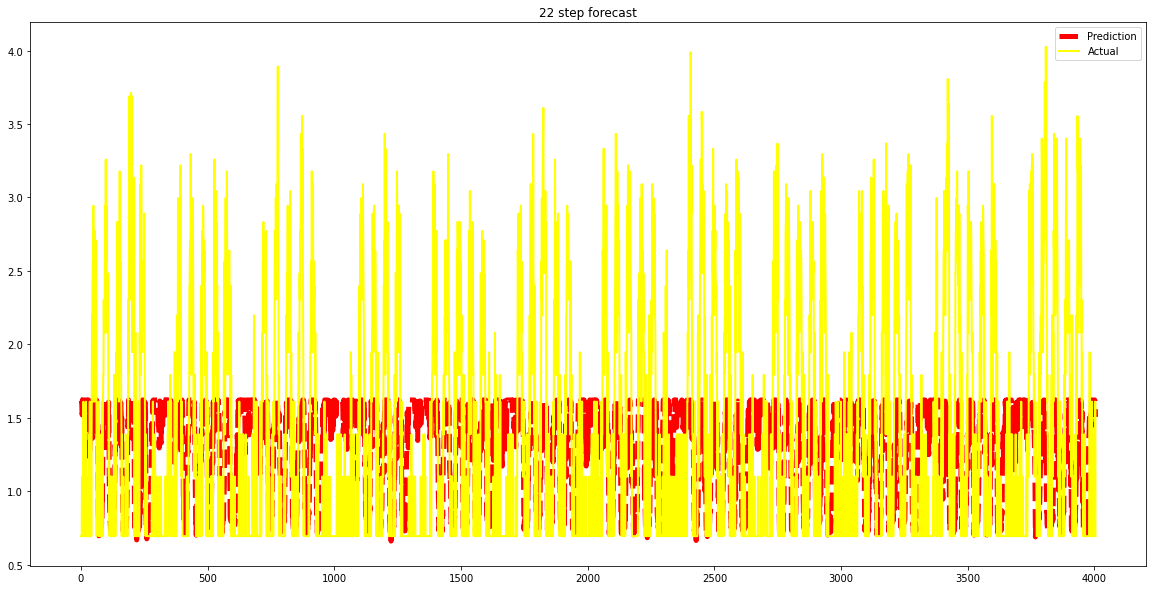

RMSE 22 step forecast: 0.7467367378327185
MAE 22 step forecast: 0.7712053705233934
MAPE 22 step forecast: 0.6630973752370435


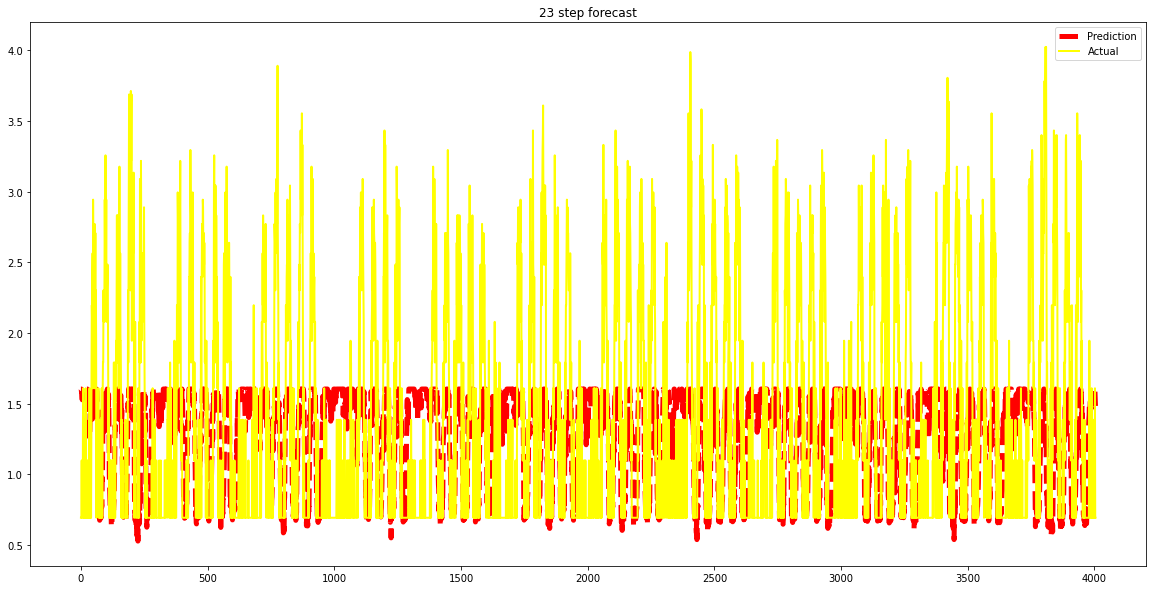

RMSE 23 step forecast: 0.7488239101117566
MAE 23 step forecast: 0.7679341737045924
MAPE 23 step forecast: 0.6636720341797394


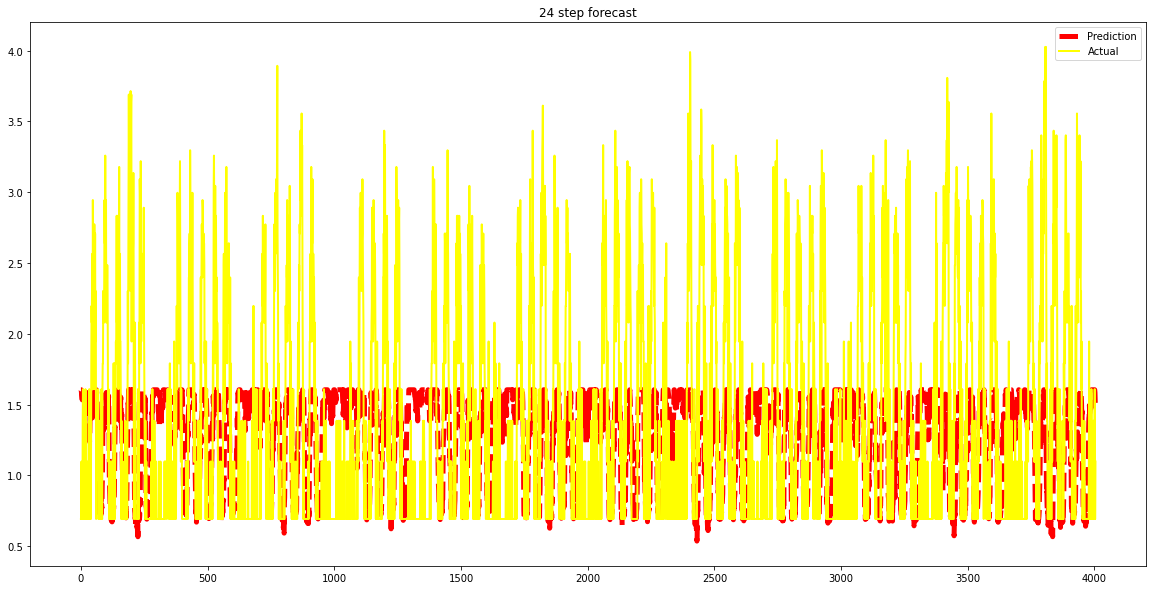

RMSE 24 step forecast: 0.7516110684402396
MAE 24 step forecast: 0.768089611273469
MAPE 24 step forecast: 0.6637811713444491


In [36]:
# train model
predictions = trainLstm(x_train, y_train, x_test, y_test, futurePeriod, 50)

In [37]:
a = 10 # prediction interval
predictions[a-1]

,Actual,Pred,Pred Interval Lower,Pred Interval Upper
0,0.693147,1.188882,0.627040,1.750723
1,0.693147,1.188882,0.627040,1.750723
2,0.693147,1.340482,0.778640,1.902323
3,0.693147,1.255385,0.693544,1.817227
4,0.693147,1.154232,0.592390,1.716074
...,...,...,...,...
4000,0.693147,1.188882,0.627040,1.750723
4001,0.693147,1.188882,0.627040,1.750723
4002,1.609438,1.340482,0.778640,1.902323
4003,0.693147,1.819742,1.257900,2.381583


In [38]:
a = 12 # prediction interval
predictions[a-1]

,Actual,Pred,Pred Interval Lower,Pred Interval Upper
0,0.693147,1.308244,0.838042,1.778445
1,0.693147,1.308244,0.838042,1.778445
2,0.693147,1.446285,0.976083,1.916486
3,0.693147,1.356501,0.886300,1.826703
4,0.693147,1.244465,0.774263,1.714666
...,...,...,...,...
4000,1.609438,1.308244,0.838042,1.778445
4001,0.693147,1.308244,0.838042,1.778445
4002,1.098612,1.446285,0.976083,1.916486
4003,1.098612,1.865005,1.394804,2.335207
